In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

In [2]:
# Datensatz laden und in DataFrame umwandeln
file_path = "../data/training_data/BTCUSDT/BTCUSDT_2022-01-01_2024-11-01_5.csv"
df = pd.read_csv(file_path)
df = pd.DataFrame(df)
df

,Timestamp,Open,High,Low,Close,Volume,Kline_Close_Time,Quote_Asset_Volume,Number_of_Trades,Taker_Buy_Base_Asset_Volume,...,BB_middle,BB_lower,Slowk,Slowd,ADX,STDDEV,Ichimoku_Conversion,Ichimoku_Base,Ichimoku_SpanA,Ichimoku_SpanB
0,2022-01-01 00:00:00,46303.98,46428.08,46300.49,46423.88,177.81820,2022-01-01 00:04:59.999000,8.243030e+06,2476,65.70076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01 00:05:00,46423.88,46450.00,46363.23,46431.30,76.40435,2022-01-01 00:09:59.999000,3.545795e+06,2319,26.06380,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01 00:10:00,46431.30,46467.67,46392.00,46430.04,46.35713,2022-01-01 00:14:59.999000,2.152665e+06,2035,28.82591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01 00:15:00,46429.65,46467.67,46406.00,46457.41,56.53522,2022-01-01 00:19:59.999000,2.625659e+06,1786,33.34084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-01 00:20:00,46457.41,46457.42,46350.67,46397.59,48.99894,2022-01-01 00:24:59.999000,2.273238e+06,2277,27.94344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298348,2024-11-01 23:40:00,69383.99,69455.28,69364.00,69440.00,30.56136,2024-11-01 23:44:59.999000,2.121544e+06,5136,19.29850,...,69212.2450,68882.971673,97.456640,88.182776,25.933330,152.236268,69344.640,69157.250,69185.9250,69667.65
298349,2024-11-01 23:45:00,69440.00,69455.95,69402.00,69438.00,15.75207,2024-11-01 23:49:59.999000,1.093685e+06,4031,6.84450,...,69217.9450,68876.793474,96.914535,95.038321,27.180309,134.789471,69344.975,69155.225,69248.5100,69644.85
298350,2024-11-01 23:50:00,69437.99,69440.00,69404.00,69420.00,18.41257,2024-11-01 23:54:59.999000,1.278162e+06,3014,10.73884,...,69226.9450,68874.048555,92.565402,95.645526,28.338536,104.129244,69344.975,69155.225,69238.0100,69608.07
298351,2024-11-01 23:55:00,69420.00,69447.20,69412.27,69440.01,11.64643,2024-11-01 23:59:59.999000,8.086257e+05,1914,5.94123,...,69237.2455,68871.683080,95.891329,95.123755,30.533787,79.920604,69344.975,69155.225,69230.0100,69608.07


In [3]:
columns_to_keep = ['Timestamp','Close', 'Volume', 'SMA_50',
       'SMA_200', 'EMA_50', 'EMA_200', 'MACD', 'MACD_Signal','MACD_Hist',
       'RSI', 'BB_upper', 'BB_middle', 'BB_lower']

df_filtered = df[columns_to_keep]
df = df_filtered.dropna()
df

,Timestamp,Close,Volume,SMA_50,SMA_200,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Hist,RSI,BB_upper,BB_middle,BB_lower
199,2022-01-01 16:35:00,47394.64,347.03626,46997.4594,46915.79470,47016.734842,46904.967712,49.547804,4.037931,45.509873,75.167767,47269.018367,47004.6610,46740.303633
200,2022-01-01 16:40:00,47342.13,117.89260,47006.3796,46920.38595,47029.495436,46909.317585,66.635828,16.557511,50.078317,83.413480,47325.327442,47020.8310,46716.334558
201,2022-01-01 16:45:00,47195.34,242.10667,47011.5054,46924.20615,47035.999145,46912.163579,67.554754,26.756960,40.797795,68.457256,47345.118300,47031.6230,46718.127700
202,2022-01-01 16:50:00,47203.86,151.07846,47016.6554,46928.07525,47042.581923,46915.066031,68.184515,35.042471,33.142044,68.488833,47364.485515,47043.3290,46722.172485
203,2022-01-01 16:55:00,47219.04,56.85857,47021.9794,46931.88340,47049.501848,46918.090648,69.111825,41.856341,27.255484,70.987893,47384.038758,47054.2765,46724.514242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298348,2024-11-01 23:40:00,69440.00,30.56136,69225.9082,69783.37195,69340.655164,69765.893774,32.079805,1.066820,31.012985,79.404467,69541.518327,69212.2450,68882.971673
298349,2024-11-01 23:45:00,69438.00,15.75207,69226.0284,69782.95190,69344.472609,69762.631149,40.550745,8.963605,31.587140,79.404467,69559.096526,69217.9450,68876.793474
298350,2024-11-01 23:50:00,69420.00,18.41257,69227.3886,69783.05185,69347.434467,69759.221884,45.289507,16.228785,29.060722,77.439645,69579.841445,69226.9450,68874.048555
298351,2024-11-01 23:55:00,69440.01,11.64643,69230.8568,69783.38185,69351.064880,69756.045647,50.082333,22.999495,27.082838,75.135471,69602.807920,69237.2455,68871.683080


In [4]:
print(df.dtypes)

Timestamp       object
Close          float64
Volume         float64
SMA_50         float64
SMA_200        float64
EMA_50         float64
EMA_200        float64
MACD           float64
MACD_Signal    float64
MACD_Hist      float64
RSI            float64
BB_upper       float64
BB_middle      float64
BB_lower       float64
dtype: object


In [11]:
def plot_technical_indicators(dataset, last_days):
    dataset = dataset.iloc[-last_days:, :]
    x_ = list(dataset.index)

    plt.figure(figsize=(16, 12), dpi=100)

    # Subplot 1: Moving Averages, Bollinger Bands, EMA, Close Price
    plt.subplot(2, 1, 1)
    plt.plot(dataset['SMA_50'], label='SMA 50', color='g', linestyle='--')
    plt.plot(dataset['SMA_200'], label='SMA 200', color='r', linestyle='--')
    plt.plot(dataset['EMA_50'], label='EMA 50', color='orange', linestyle='--')
    plt.plot(dataset['EMA_200'], label='EMA 200', color='purple', linestyle='--')
    plt.plot(dataset['Close'], label='Closing Price', color='b')
    plt.plot(dataset['BB_upper'], label='Upper Band', color='c', linestyle='--')
    plt.plot(dataset['BB_lower'], label='Lower Band', color='c', linestyle='--')
    plt.fill_between(x_, dataset['BB_lower'], dataset['BB_upper'], color='c', alpha=0.1)
    plt.title('Technische Indikatoren - Letzte {} Werte'.format(last_days))
    plt.xlabel('Datum')
    plt.ylabel('Preis (USD)')
    plt.legend()

    # Subplot 2: MACD and RSI
    plt.subplot(2, 1, 2)
    plt.title('MACD und RSI')
    plt.plot(dataset['MACD'], label='MACD', color='b', linestyle='-.')
    plt.plot(dataset['MACD_Signal'], label='MACD Signal', color='r', linestyle='--')
    plt.fill_between(x_, dataset['MACD_Hist'], 0, alpha=0.5, label='MACD Histogramm', color='gray')
    plt.plot(dataset['RSI'], label='RSI', color='g')
    plt.xlabel('Datum')
    plt.ylabel('Indikator-Wert')
    plt.legend()

    plt.tight_layout()
    plt.show()


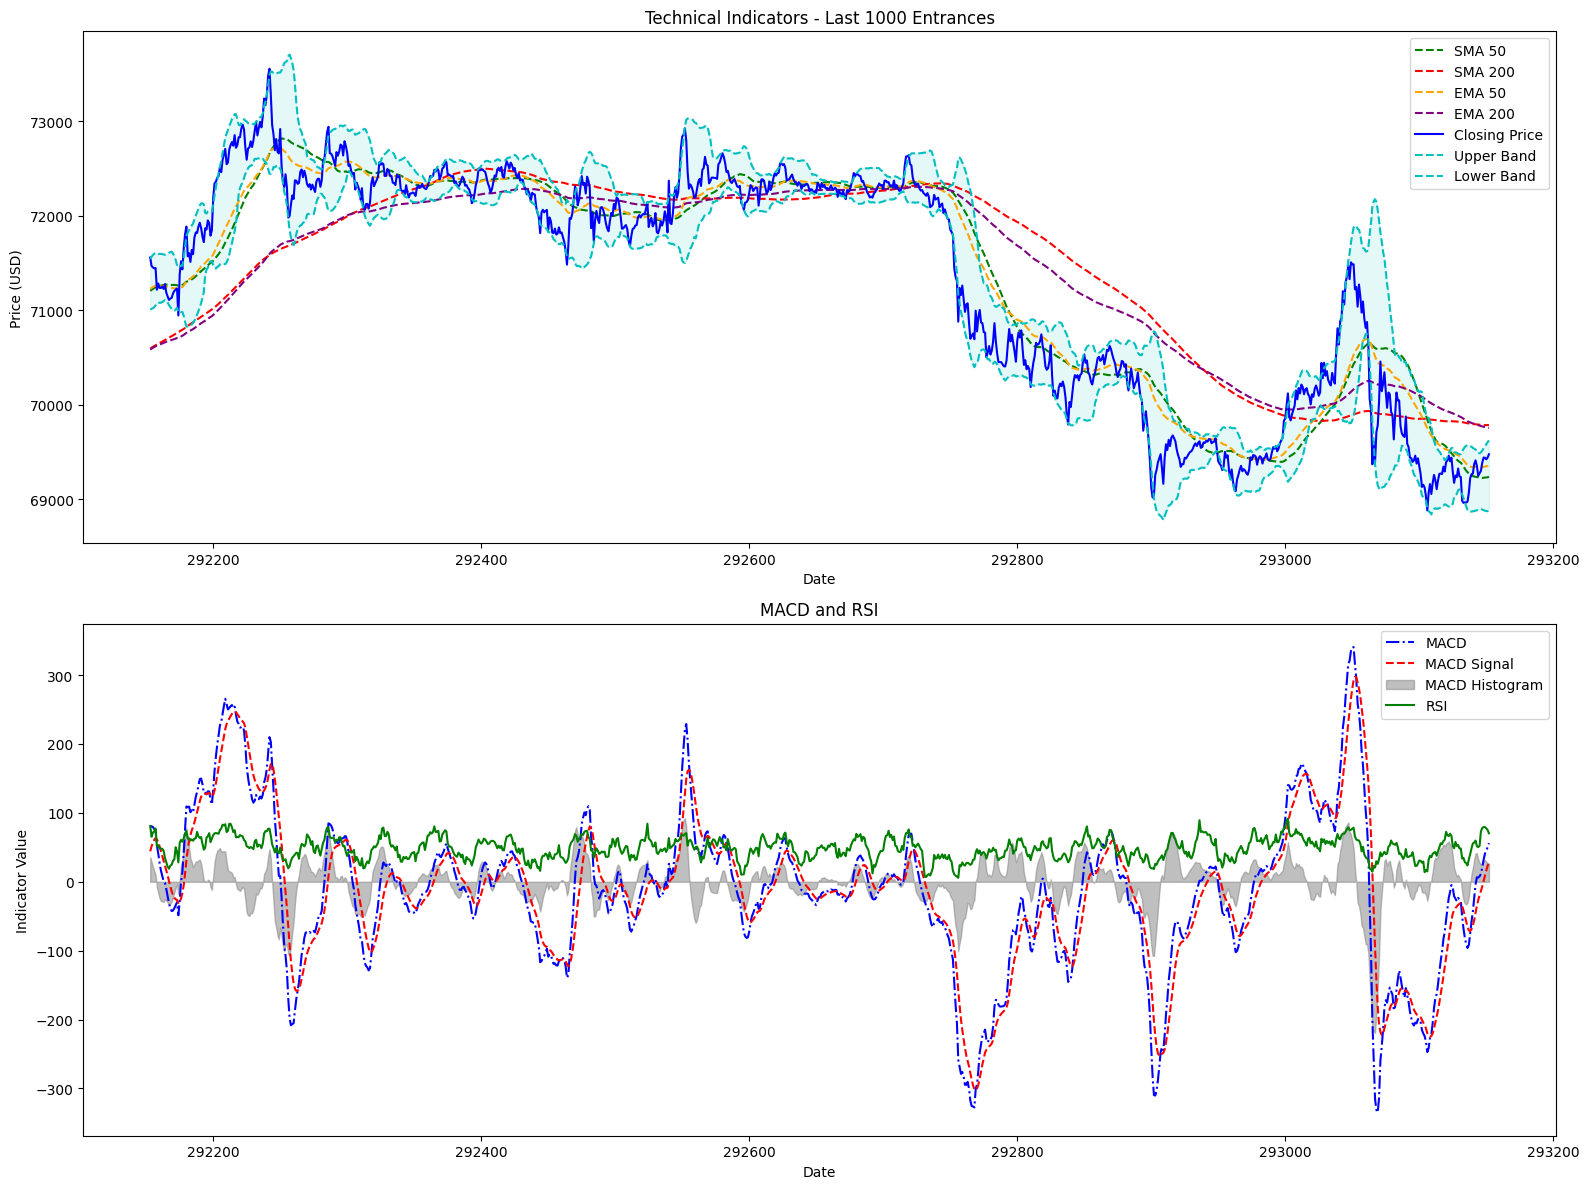

293153


In [12]:
plot_technical_indicators(df, 1000)
print(len(df))

In [7]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 298153 samples, and 14 features.


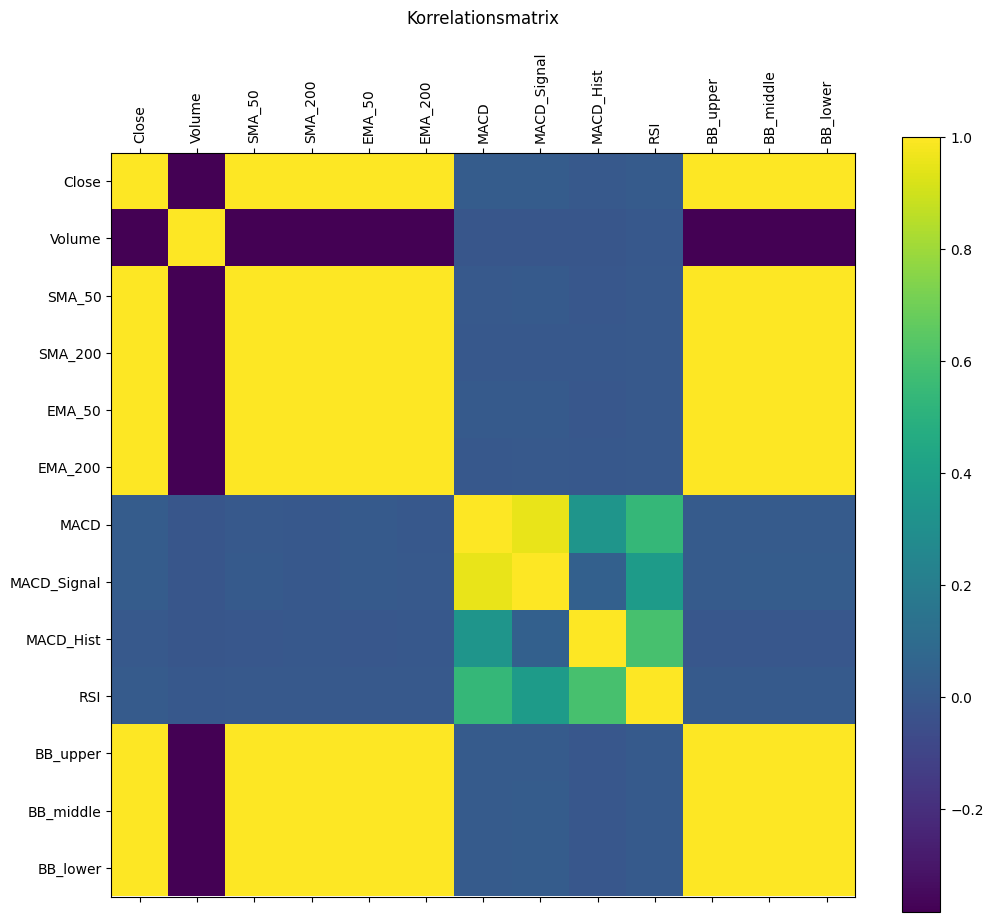

In [8]:
correlation_matrix = df.select_dtypes(include=[np.float64]).corr()

# Visualisierung der Korrelationsmatrix
plt.figure(figsize=(12, 10))
plt.matshow(correlation_matrix, fignum=1)
plt.xticks(range(correlation_matrix.shape[1]), correlation_matrix.columns, rotation=90)
plt.yticks(range(correlation_matrix.shape[1]), correlation_matrix.columns)
plt.colorbar()
plt.title("Korrelationsmatrix", pad=20)
plt.show()

df = df.iloc[5000:].reset_index(drop=True)

In [9]:
prices = df['Close'].values.reshape(-1, 1)
print(prices)

[[42247.46]
 [42319.59]
 [42454.9 ]
 ...
 [69420.  ]
 [69440.01]
 [69474.72]]
